In [581]:
import pandas as pd
import os
import numpy as np
import h5py
import torch

#### Global variables

In [582]:
SEED = 123
#Hyperparameters
num_epochs_global = 15
batch_size_global = 32
num_neurons_1hl = 14
num_neurons_2hl = 10



#Plotting
font_size = 16
header_font_size = 20

# Data Preprocessing

In [583]:
mat_file = "original_dataset/ReadBrownDwarf.mat"
data_path = "original_dataset/"
idTE = np.load(data_path + "idTE.npy")
idTR = np.load(data_path + "idTR.npy")
labelTE = np.load(data_path + "labelTE.npy")
labelTR = np.load(data_path + "labelTR.npy")

In [584]:
#Extracting the data from the mat file
with h5py.File(mat_file, 'r') as f:
    data = f["data"]
    data = pd.DataFrame(data).T
data

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,326.808170,2.686124,5.5560,0.0000,5.7600,0.0000,5.9470,0.0000,6.0720,0.0000,...,0.162,0.050,0.015,0.044,5.562,5.539,5.479,0.017,0.026,0.020
1,321.200440,25.880459,0.0000,0.0000,7.6116,0.0010,0.0000,0.0000,7.5167,0.0010,...,0.059,0.020,0.016,0.059,6.896,6.921,6.932,0.026,0.024,0.016
2,144.038450,-12.459262,10.5120,0.0000,10.6920,0.0000,10.8660,0.0000,10.9890,0.0000,...,0.022,0.020,0.074,0.000,10.408,10.400,10.378,0.026,0.021,0.023
3,209.662170,21.696203,0.0000,0.0000,0.0000,0.0000,6.8603,0.1042,0.0000,0.0000,...,0.149,0.046,0.015,0.037,5.671,5.717,5.704,0.023,0.063,0.020
4,65.162550,-20.639620,0.0000,0.0000,0.0000,0.0000,6.3206,0.0000,5.9504,0.0031,...,0.169,0.072,0.015,0.036,5.430,5.402,5.333,0.054,0.036,0.017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5664,13.245956,49.443574,9.1227,0.2347,9.1823,0.0010,0.0000,0.0000,9.0066,0.0010,...,0.022,0.019,0.021,0.144,8.358,8.389,8.398,0.027,0.017,0.016
5665,29.647854,48.432832,0.0000,0.0000,9.5538,0.0010,0.0000,0.0000,10.7253,0.0010,...,0.023,0.019,0.026,0.297,8.778,8.804,8.766,0.021,0.016,0.020
5666,346.990957,54.326940,0.0000,0.0000,9.8405,0.0010,9.2025,0.0010,10.1089,0.0374,...,0.024,0.020,0.030,0.327,9.180,9.187,9.180,0.021,0.020,0.022
5667,331.173131,46.427253,10.4915,0.0630,10.2538,0.0239,10.0057,0.0074,10.4418,0.0315,...,0.023,0.020,0.033,0.000,9.693,9.678,9.622,0.024,0.029,0.023


Data imputation



Instead of replacing zero-entries with the mean of the column, we train a linear regression model on the rows with complete data and make the model predict on our missing values.

In [585]:
from sklearn.linear_model import LinearRegression
np.random.seed(SEED)
# Check which columns have zero values
columns_with_zero = data.columns[(data == 0).any()].tolist()

print(columns_with_zero)
# Identify the target column
target_columns = columns_with_zero

# Split the dataframe into two: one with zero values and one without
for target_column in target_columns:
    df_zeros = data[data[target_column] == 0]
    df_no_zeros = data[data[target_column] != 0]

    # Create X_train, y_train from df_no_zeros
    X_train = df_no_zeros.drop(columns=target_column)
    y_train = df_no_zeros[target_column]

    # Create X_test from df_zeros
    X_test = df_zeros.drop(columns=target_column)

    # Use a machine learning model to train on X_train and y_train
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict the y_test values using the trained model and X_test
    y_test = model.predict(X_test)

    # Replace the zero values in the original dataframe
    data.loc[data[target_column] == 0, target_column] = y_test

data

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,326.808170,2.686124,5.556000,0.059167,5.760000,0.021935,5.947000,0.029627,6.072000,0.060598,...,0.162,0.050,0.015,0.044000,5.562,5.539,5.479,0.017,0.026,0.020
1,321.200440,25.880459,6.949315,0.043727,7.611600,0.001000,10.151751,0.036496,7.516700,0.001000,...,0.059,0.020,0.016,0.059000,6.896,6.921,6.932,0.026,0.024,0.016
2,144.038450,-12.459262,10.512000,0.027487,10.692000,0.006986,10.866000,0.022590,10.989000,0.032279,...,0.022,0.020,0.074,0.251253,10.408,10.400,10.378,0.026,0.021,0.023
3,209.662170,21.696203,4.345528,0.056622,4.037855,0.036545,6.860300,0.104200,7.209748,0.074807,...,0.149,0.046,0.015,0.037000,5.671,5.717,5.704,0.023,0.063,0.020
4,65.162550,-20.639620,4.296942,0.037534,4.482331,0.022628,6.320600,0.042920,5.950400,0.003100,...,0.169,0.072,0.015,0.036000,5.430,5.402,5.333,0.054,0.036,0.017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5664,13.245956,49.443574,9.122700,0.234700,9.182300,0.001000,9.055370,0.062617,9.006600,0.001000,...,0.022,0.019,0.021,0.144000,8.358,8.389,8.398,0.027,0.017,0.016
5665,29.647854,48.432832,9.350538,0.028667,9.553800,0.001000,10.713987,0.042682,10.725300,0.001000,...,0.023,0.019,0.026,0.297000,8.778,8.804,8.766,0.021,0.016,0.020
5666,346.990957,54.326940,10.484746,0.039431,9.840500,0.001000,9.202500,0.001000,10.108900,0.037400,...,0.024,0.020,0.030,0.327000,9.180,9.187,9.180,0.021,0.020,0.022
5667,331.173131,46.427253,10.491500,0.063000,10.253800,0.023900,10.005700,0.007400,10.441800,0.031500,...,0.023,0.020,0.033,0.224542,9.693,9.678,9.622,0.024,0.029,0.023


Since we have imputed the missing values using a ML model we want to scale the data as we do not know what the variance of our predictions.

Splitting into training and test data before scaling it

In [586]:
from sklearn.preprocessing import StandardScaler

#Splitting in training and test data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []
for i in range(len(idTR)):
    X_train_list.append(data.iloc[idTR[i] - 1]) #idTR is 1 indexed
    X_test_list.append(data.iloc[idTE[i] - 1])  #idTE is 1 indexed
    y_train_list.append(labelTR[i])
    y_test_list.append(labelTE[i])
    #Scaling
    scaler = StandardScaler()
    X_train_list[i] = scaler.fit_transform(X_train_list[i])
    X_test_list[i] = scaler.transform(X_test_list[i])

X_train_arr = np.array(X_train_list)
X_test_arr = np.array(X_test_list)
y_train_arr = np.array(y_train_list)
y_test_arr = np.array(y_test_list)

In [587]:
X_train_arr.shape, X_test_arr.shape, y_train_arr.shape, y_test_arr.shape

((5, 4535, 26), (5, 1134, 26), (5, 4535), (5, 1134))

# NN

Network structure: $26$ x $14$ x $10$ x $1$

In [588]:
torch.manual_seed(SEED) # Added seed for reproducibility for all the activation functions

In [589]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



# Convert numpy arrays or pandas DataFrames to PyTorch tensors if needed
X_train_tens = torch.tensor(X_train_arr, dtype=torch.float32)
y_train_tens = torch.tensor(y_train_arr, dtype=torch.long)

# Defining a simple neural network class for binary classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, activation=nn.ReLU()):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, num_neurons_1hl)
        self.activation = activation
        self.fc2 = nn.Linear(num_neurons_1hl, num_neurons_2hl)
        self.fc3 = nn.Linear(num_neurons_2hl, 1)# Output layer with single neuron (binary classification)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Apply sigmoid activation for binary classification of final output
        return x


## Training Loop

In [590]:
from sklearn.model_selection import train_test_split


losses_fold = []


val_losses = []  # Store validation losses
all_losses = []  # Store training losses for all folds
all_val_losses = []  # Store validation losses for all folds

for i in range(len(X_train_tens)):
    # Initializing
    input_size = X_train_tens[i].shape[1]
    model = NeuralNet(input_size)


    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters())

    # Prepare data for training using DataLoader
    batch_size = batch_size_global
    X_train, X_val, y_train, y_val = train_test_split(X_train_tens[i], y_train_tens[i], test_size=0.2)  # Split data into training and validation sets

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)  # Create validation dataset

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Create validation DataLoader

    # Training loop
    # Training loop
    temp_loss = []
    num_epochs = num_epochs_global
    losses = []  # Store training losses for this fold
    val_losses = []  # Store validation losses for this fold
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze(dim=1)  # Remove extra dimension for binary classification
            loss = criterion(outputs, labels.float())  # Calculate loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        temp_loss.append(running_loss / len(train_loader))
    
        # Calculate validation loss
        val_loss = 0.0
        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                outputs = outputs.squeeze(dim=1)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item()

        model.train()  # Switch back to training mode

        # Store losses
        losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")
    losses_fold.append(temp_loss)
    all_losses.append(losses)
    all_val_losses.append(val_losses)

    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        predictions = model(X_train_tens[i])
        predictions = (predictions > 0.5).int()  # Convert probabilities to binary predictions (0 or 1)


    dir_path = './models/'
    # Check if the directory exists
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    #Saving model for later use
    model_dir = './models/'
    os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
    model_path = os.path.join(model_dir, f'fold{i}_binary_classification_model.pth')
    torch.save(model.state_dict(), model_path)


    # Calculate mean losses
mean_losses = np.array([sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*all_losses)])
mean_val_losses = np.array([sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*all_val_losses)])
print(mean_losses)
print(mean_val_losses)
for epoch in range(num_epochs_global):
    print(f"Epoch {epoch+1}, Mean Training Loss: {mean_losses[epoch]}, Mean Validation Loss: {mean_val_losses[epoch]}")

Epoch 1, Loss: 0.5174820295028519
Epoch 1, Loss: 0.5174820295028519, Validation Loss: 0.35587359348247793
Epoch 2, Loss: 0.24407370774108067
Epoch 2, Loss: 0.24407370774108067, Validation Loss: 0.14880667472707815
Epoch 3, Loss: 0.11588632838245023
Epoch 3, Loss: 0.11588632838245023, Validation Loss: 0.07884345858775337
Epoch 4, Loss: 0.07785974781992927
Epoch 4, Loss: 0.07785974781992927, Validation Loss: 0.056218701960711645
Epoch 5, Loss: 0.06406084524892401
Epoch 5, Loss: 0.06406084524892401, Validation Loss: 0.04646757624015726
Epoch 6, Loss: 0.05635473607598167
Epoch 6, Loss: 0.05635473607598167, Validation Loss: 0.04387870544953079
Epoch 7, Loss: 0.05452145543357913
Epoch 7, Loss: 0.05452145543357913, Validation Loss: 0.03832118482939128
Epoch 8, Loss: 0.04870580637157617
Epoch 8, Loss: 0.04870580637157617, Validation Loss: 0.03528109313277849
Epoch 9, Loss: 0.04640187727891954
Epoch 9, Loss: 0.04640187727891954, Validation Loss: 0.03512235343905872
Epoch 10, Loss: 0.04479259857

In [591]:
losses_fold = np.array(losses_fold)
losses_fold.shape

(5, 15)

In [592]:
mean_losses.shape, mean_val_losses.shape

((15,), (15,))

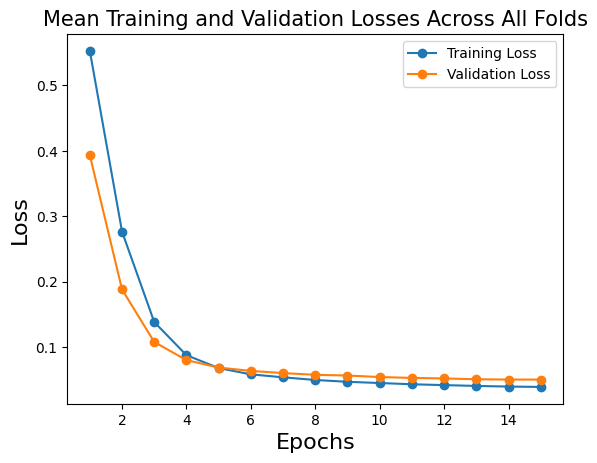

In [593]:
import matplotlib.pyplot as plt

# Calculate mean losses
#mean_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*all_losses)]
#mean_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*all_val_losses)]

# Create a new figure
plt.figure()

# Plot mean training losses
plt.plot(range(1, num_epochs+1), mean_losses, "-o", label='Training Loss')

# Plot mean validation losses
plt.plot(range(1, num_epochs+1), mean_val_losses, "-o", label='Validation Loss')

# Add title and labels
plt.title('Mean Training and Validation Losses Across All Folds', fontsize = header_font_size-5)
plt.xlabel('Epochs', fontsize = font_size)
plt.ylabel('Loss', fontsize = font_size )

# Add legend
plt.legend()

# Show the plot
plt.show()

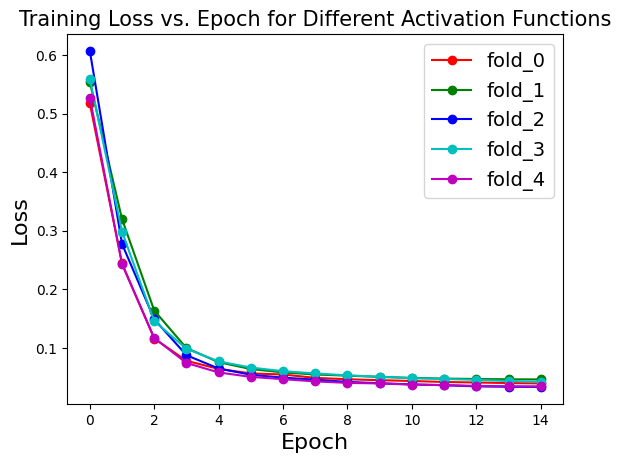

In [594]:
import matplotlib.pyplot as plt

fold_colors = ['r', 'g', 'b', 'c', 'm']
for i, loss in enumerate(losses_fold):
    plt.plot(loss, "-o", label=f"fold_{i}", color=fold_colors[i % len(fold_colors)])
plt.legend(fontsize = font_size - 2)
plt.xlabel("Epoch", size = font_size)
plt.ylabel("Loss", size = font_size)
plt.title("Training Loss vs. Epoch for Different Activation Functions", size = header_font_size - 5)
plt.show()

Predicting on training data

In [595]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix

mcc_scores = []
for i in range(len(X_train_tens)):
    print(f"Evaluating model on fold: {i}")
    # Load the trained model
    input_size = input_size 
    model = NeuralNet(input_size)
    model.load_state_dict(torch.load(f'models/fold{i}_binary_classification_model.pth'))  # Load the trained model state (MACos)

    X_train = X_train_tens[i].float()
    y_train = y_train_tens[i].float()

    # Prepare test dataset and dataloader
    batch_size = batch_size_global
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc_tr = matthews_corrcoef(y_true, y_pred)
    mcc_scores.append(mcc_tr)

    print(f"Training: MCC-score: {mcc_tr}, check against the test set for overfitting")

print(f"Mean MCC score on training set: {np.mean(mcc_scores)}")

Evaluating model on fold: 0
Training: MCC-score: 0.9758322223960791, check against the test set for overfitting
Evaluating model on fold: 1
Training: MCC-score: 0.9720144173519509, check against the test set for overfitting
Evaluating model on fold: 2
Training: MCC-score: 0.9701772673182091, check against the test set for overfitting
Evaluating model on fold: 3
Training: MCC-score: 0.9709831566634997, check against the test set for overfitting
Evaluating model on fold: 4
Training: MCC-score: 0.9763401314061926, check against the test set for overfitting
Mean MCC score on training set: 0.9730694390271865


## Testing the model on the test set

In [596]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix

mcc_scores = []
all_metrics = {}
all_confusion_matrices = {}
for i in range(len(X_train_tens)):
    print(f"Evaluating model on fold: {i}")
    # Load the trained model
    input_size = input_size  
    model = NeuralNet(input_size)
    model.load_state_dict(torch.load(f'models/fold{i}_binary_classification_model.pth'))  # Load the trained model state (MACos)


    X_test = torch.tensor(X_test_arr[i], dtype=torch.float32)
    y_test = torch.tensor(y_test_arr[i], dtype=torch.float32)

    # Prepare test dataset and dataloader
    batch_size = batch_size_global
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculating different scoring methods
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred) # Calculate Matthews Correlation Coefficient (MCC)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary') 
    recall = recall_score(y_true, y_pred, average='binary')   
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[1,0])

    # Store the metrics in a dictionary for easy plotting
    metrics = {'F1 Score': f1, 'MCC': mcc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
    
    all_metrics[f"fold_{i}"] = metrics
    all_confusion_matrices[f"fold_{i}"] = conf_matrix

    
    print(f"Testing MCC score: {metrics['MCC']}")
    mcc_scores.append(metrics['MCC'])

print(f"Mean MCC on TEST SET: {np.mean(mcc_scores)}")

Evaluating model on fold: 0
Testing MCC score: 0.9678076451844143
Evaluating model on fold: 1
Testing MCC score: 0.9717499471944918
Evaluating model on fold: 2
Testing MCC score: 0.9740143382948381
Evaluating model on fold: 3
Testing MCC score: 0.9848268487213596
Evaluating model on fold: 4
Testing MCC score: 0.9533048129414927
Mean MCC on TEST SET: 0.9703407184673194


It is expected that 𝑧𝑃𝑆1 −𝐽 is the most important feature as Burningham et al. (2013), which we used as a baseline, is nearly entirely based on the above colour. However, it only plays a secondary role in most of the models. Unlike the
previous works, we revealed the importance of the (𝑖−𝑦)𝑃 𝑆1 colour index. It is the most important feature in most cases and the colour selection (𝑖 − 𝑦)𝑃𝑆1 > 1.88 alone gives an MCC score of 0.968 on the testing data.

(0.8, 1.0)

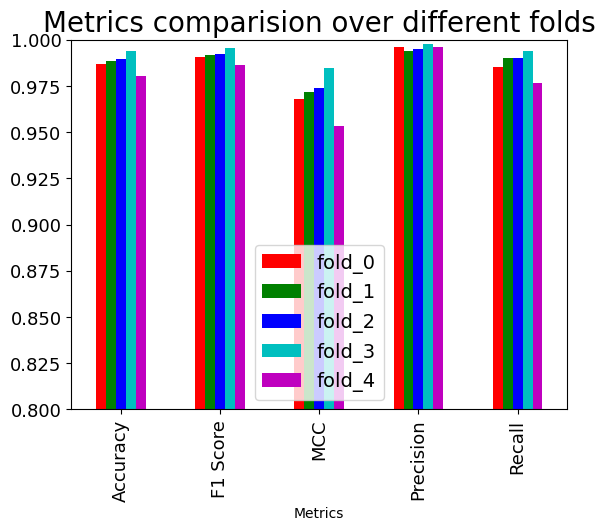

In [597]:
data = pd.DataFrame(all_metrics)
data = data.reset_index().rename(columns={'index': 'Metrics'})


data = pd.melt(data, id_vars='Metrics', var_name='Fold', value_name='Value')

data = data.set_index(['Metrics', 'Fold']).Value
data.unstack().plot(kind='bar', stacked=False, color = fold_colors, fontsize = font_size-3)
plt.legend(fontsize = font_size-2)
plt.title("Metrics comparision over different folds", size = header_font_size)
plt.ylim(0.8,1)

[0.9878306878306878, 0.9914834539393127, 0.9711906435579148, 0.9957913200480926, 0.9872317269863282]
['Accuracy', 'F1 Score', 'MCC', 'Precision', 'Recall']


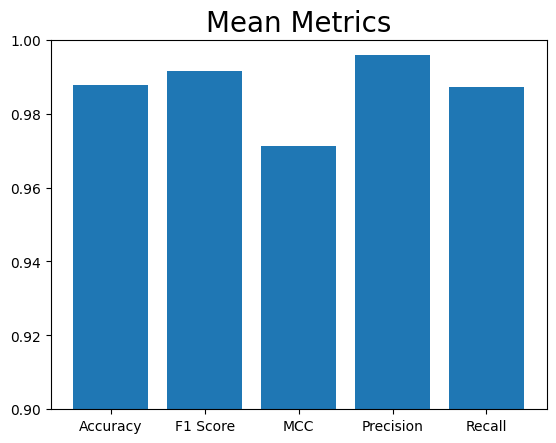

In [598]:
mean_Accuracy = np.mean(data['Accuracy'])
mean_F1_score = np.mean(data['F1 Score'])
mean_MCC      = np.mean(data['MCC'][:3])
mean_Precision= np.mean(data['Precision'])
mean_Recall   = np.mean(data['Recall'])

Mean_metrics = [mean_Accuracy, mean_F1_score, mean_MCC, mean_Precision, mean_Recall]
names = ["Accuracy", "F1 Score", "MCC", "Precision", "Recall"]

# Mean_metrics.unstack().plot(kind='bar', stacked=False, color = fold_colors, fontsize = font_size-3)
plt.bar(names, Mean_metrics)
plt.title("Mean Metrics", size = header_font_size)
plt.ylim(0.9,1)

print(Mean_metrics)
print(names)

## Confusion matrix comparison

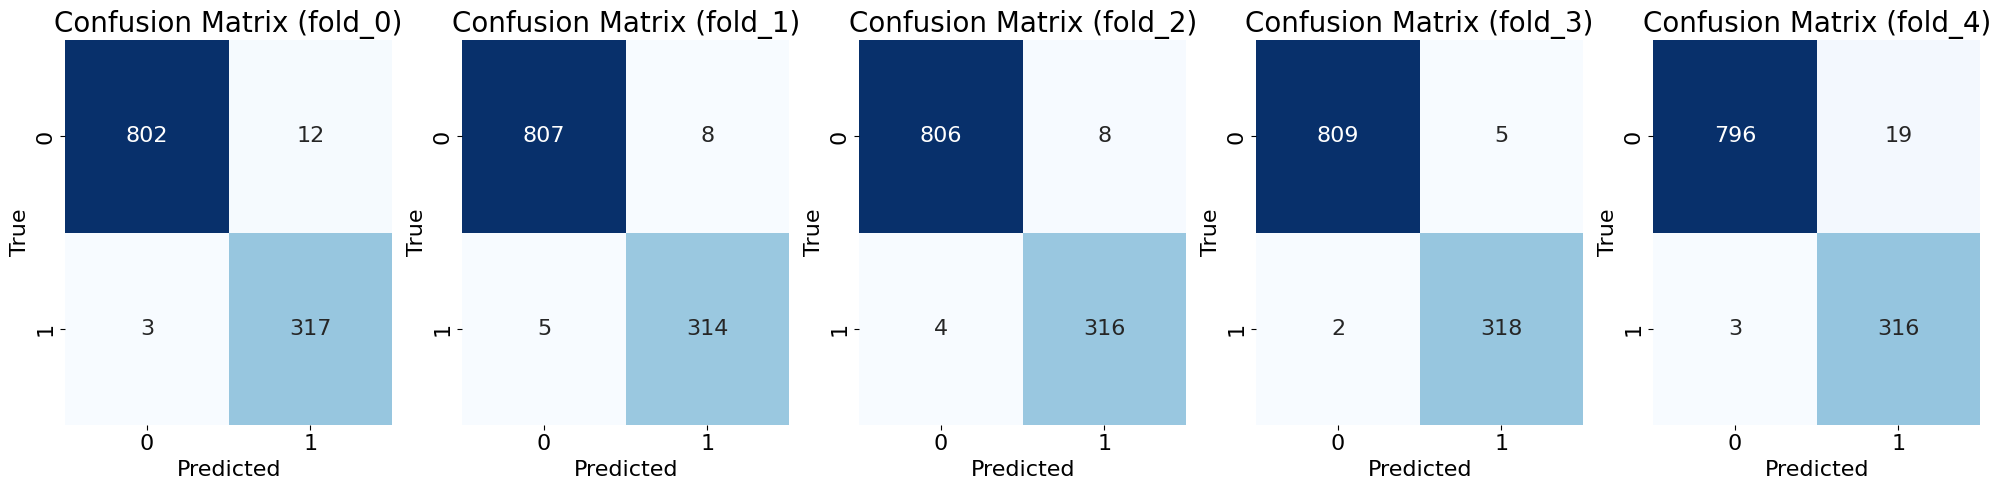

In [599]:
import seaborn as sns

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(len(X_train_tens)):
    conf_matrix = all_confusion_matrices[f"fold_{i}"]

    # Create a heatmap for the confusion matrix for the i-th fold
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar = False, annot_kws={"size": font_size})

    axes[i].set_title(f'Confusion Matrix (fold_{i})', size = header_font_size)
    axes[i].set_xlabel('Predicted', size = font_size)
    axes[i].set_ylabel('True', size = font_size)
    axes[i].tick_params(axis='both', which='major', labelsize=font_size)

plt.tight_layout()
plt.show()

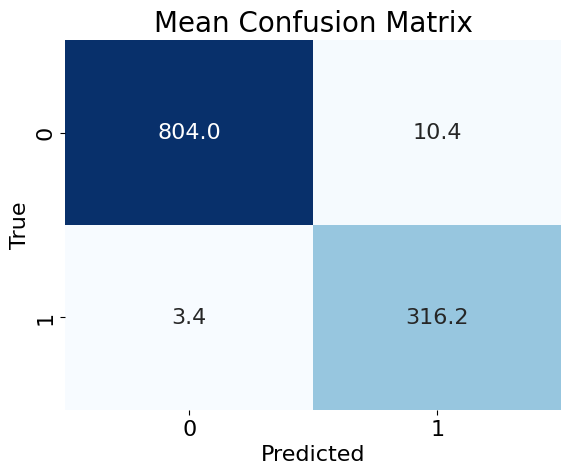

In [600]:
import statistics

temp_conf_matrix = np.zeros((2,2))

for fold, conf_values in all_confusion_matrices.items():
    for i in range(len(conf_values)):
        for j in range(len(conf_values[i])):
            temp_conf_matrix[i][j] += conf_values[i][j]
average_conf_matrix = temp_conf_matrix/5


sns.heatmap(average_conf_matrix, annot=True, fmt='.1f', cmap='Blues', cbar = False, annot_kws={"size": font_size})

plt.title(f'Mean Confusion Matrix', size = header_font_size)
plt.xlabel('Predicted', size = font_size)
plt.ylabel('True', size = font_size)
plt.tick_params(axis='both', which='major', labelsize=font_size)